# QBUS6830: Group Assignment - Part 1
## Group 4
### SIDs: 510109707, 500227060 ,
---

## Question 1 - Principle Components and Factor Analyses

#### a) Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import norm
from datetime import datetime
from statsmodels.stats.stattools import jarque_bera
from statsmodels.multivariate.pca import PCA
from statsmodels.multivariate.factor import Factor
from statsmodels.multivariate.factor_rotation import rotate_factors
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

Necessary libraries and modules are imported.

#### b) Importing data

In [3]:
#Importing data 
data1 = pd.read_csv('my_group_data-copy.csv', index_col='Date', parse_dates=True, dayfirst=True)

#### c) Inspecting data

In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2532 entries, 2011-09-26 to 2021-09-24
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RIO.AX  2532 non-null   float64
 1   TLS.AX  2532 non-null   float64
 2   WES.AX  2532 non-null   float64
 3   CPU.AX  2532 non-null   float64
 4   SEK.AX  2532 non-null   float64
 5   WOW.AX  2532 non-null   float64
 6   CBA.AX  2532 non-null   float64
 7   WBC.AX  2532 non-null   float64
dtypes: float64(8)
memory usage: 178.0 KB


The data is quickly inspected to ascertain the presence of missing values. Indeed, before working on the dataset, the variables CPU, CBA and WBC contained missing values as stocks haven't been trading (Trading Volume=0) on some few days over the past years. 

Therefore, we decided to proceed via imputation to resolve the issue.
Precisely, the missing values have been imputed with the last available adjusted closing price of the respective stock.

The reason for the choice is that past day prices are a good proxy and that on those specific days no market events happened that could have changed the price significantly.

Also, we decided not to proceed with the dropping of entire observations as the remaining stocks could have experienced particular price behaviours on those specific days. Thus, potentially leading to the distortion of the analysis.

In [5]:
data1.head()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-26,39.712032,1.942921,12.923607,5.573087,3.980642,17.424408,26.109711,11.411721
2011-09-27,41.836163,1.955703,13.381684,5.678382,4.223364,17.522896,27.121952,12.042071
2011-09-28,42.251755,1.974877,13.521650,5.731029,4.304272,17.642477,27.092180,12.279938
2011-09-29,41.196289,1.974877,13.428337,5.685903,4.263817,17.586203,27.098141,12.220470
2011-09-30,40.767490,1.981268,13.398647,5.618213,4.304272,17.487720,27.121952,12.095592


In [6]:
data1.tail()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2021-09-20,95.239998,3.88,56.900002,16.280001,29.590000,39.209999,100.809998,25.299999
2021-09-21,95.709999,3.93,57.389999,16.510000,29.709999,39.360001,100.339996,25.190001
2021-09-22,98.269997,3.95,57.230000,16.330000,29.860001,39.250000,99.639999,24.910000
2021-09-23,98.860001,3.98,57.490002,16.930000,30.490000,39.060001,100.800003,25.070000
2021-09-24,99.330002,3.95,57.360001,17.900000,30.530001,39.290001,101.699997,25.250000


#### d) Calculating log-returns (%)

In [7]:
x = np.log(data1).diff() * 100
x

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-27,5.210688,0.655750,3.483130,1.871724,5.918904,0.563638,3.803614,5.376546
2011-09-28,0.988479,0.975614,1.040520,0.922870,1.897590,0.680110,-0.109830,1.956039
2011-09-29,-2.529770,0.000000,-0.692494,-0.790514,-0.944311,-0.319481,0.021998,-0.485440
2011-09-30,-1.046322,0.323089,-0.221343,-1.197638,0.944311,-0.561570,0.087832,-1.027140
...,...,...,...,...,...,...,...,...
2021-09-20,-3.669764,-1.025649,-0.665613,-2.247279,-3.421695,-0.458017,-2.032570,-2.266607
2021-09-21,0.492278,1.280426,0.857469,1.402887,0.404719,0.381829,-0.467315,-0.435725
2021-09-22,2.639598,0.507615,-0.279183,-1.096237,0.503615,-0.279864,-0.700070,-1.117779


Percentage Log-returns are calculated from the original Adjusted Closing Price data.

In [8]:
# Taking out 1st row because it contains NaN values
log_r = x.iloc[1: , :]
log_r

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-27,5.210688,0.655750,3.483130,1.871724,5.918904,0.563638,3.803614,5.376546
2011-09-28,0.988479,0.975614,1.040520,0.922870,1.897590,0.680110,-0.109830,1.956039
2011-09-29,-2.529770,0.000000,-0.692494,-0.790514,-0.944311,-0.319481,0.021998,-0.485440
2011-09-30,-1.046322,0.323089,-0.221343,-1.197638,0.944311,-0.561570,0.087832,-1.027140
2011-10-04,-4.636567,-3.278966,-5.031071,-4.238481,-4.027383,-1.826718,-4.582002,-5.041383
...,...,...,...,...,...,...,...,...
2021-09-20,-3.669764,-1.025649,-0.665613,-2.247279,-3.421695,-0.458017,-2.032570,-2.266607
2021-09-21,0.492278,1.280426,0.857469,1.402887,0.404719,0.381829,-0.467315,-0.435725
2021-09-22,2.639598,0.507615,-0.279183,-1.096237,0.503615,-0.279864,-0.700070,-1.117779


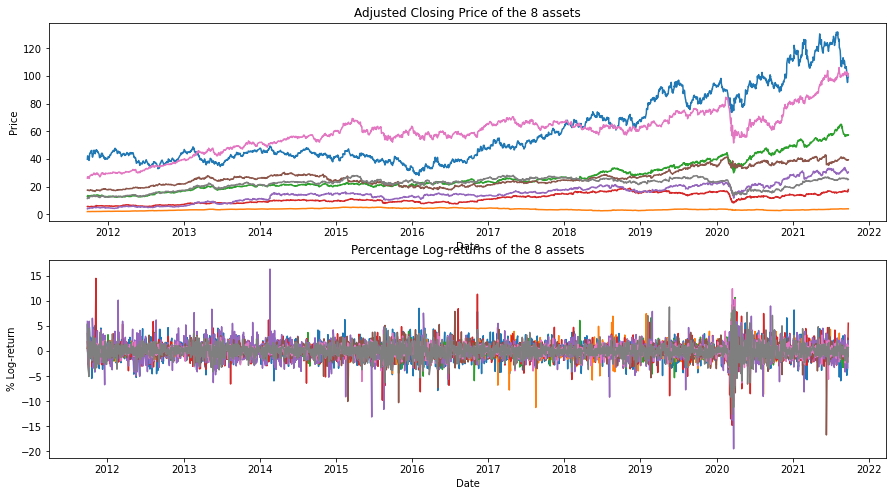

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

ax[0].plot(data1)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].set_title('Adjusted Closing Price of the 8 assets')

ax[1].plot(log_r)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('% Log-return')
ax[1].set_title('Percentage Log-returns of the 8 assets')

plt.show()

As clearly observable from the above graphs, adjusted closing prices of all 8 assets seems to be neither mean or variance stationary as they don't seem to revert to a mean. Indeed, they appear to follow a random walk.

However, log-returns might be mean stationary as they seem to revert to a mean close to 0. Thus, making them useful for our next time series analyses and forecasting methods.

---
## Principal Component Analysis (PCA)

In [10]:
corr_m = log_r.corr().round(4)
corr_m

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.0000,0.2190,0.3132,0.3253,0.2800,0.2597,0.4035,0.4003
TLS.AX,0.2190,1.0000,0.4322,0.2416,0.2387,0.3472,0.3868,0.3387
WES.AX,0.3132,0.4322,1.0000,0.3806,0.4049,0.5571,0.5632,0.5069
CPU.AX,0.3253,0.2416,0.3806,1.0000,0.4081,0.2788,0.4579,0.4620
SEK.AX,0.2800,0.2387,0.4049,0.4081,1.0000,0.2877,0.4324,0.4123
WOW.AX,0.2597,0.3472,0.5571,0.2788,0.2877,1.0000,0.4498,0.3700
CBA.AX,0.4035,0.3868,0.5632,0.4579,0.4324,0.4498,1.0000,0.8298
WBC.AX,0.4003,0.3387,0.5069,0.4620,0.4123,0.3700,0.8298,1.0000


To conduct PCA, the variables have to be correlated beetween each other. However, not perfectly correlated (correlation =1). From the correlation matrix above, all the pairwise correlations are different from zero and 1, which indicates the data is fit for PCA.

In [11]:
#PCA Implementation
class MyPca:
    def __init__(self, log_r):
        self.log_r = log_r.values
        self.n = self.log_r.shape[0]
        self.d = self.log_r.shape[1]
        self.mu = np.mean(self.log_r, axis=0)
        self.eigval = None
        self.weight = None

    def fit(self):
        c = np.cov(self.log_r.T)
        eigval, weight = np.linalg.eig(c)
        idx = np.argsort(-eigval)
        self.eigval = eigval[idx]
        self.weight = weight[:, idx]
    
    def transform(self, n_comp):
        x = self.log_r - np.tile(self.mu, (self.n, 1))
        return np.dot(x, self.weight[:, :n_comp])
    
    def prop_var_explained(self):
        return self.eigval / np.sum(self.eigval)
    
    def biplot2d(self):
        ax = plt.axes()
        for i in range(self.d):
            w = self.weight[i, :]
            ax.plot([0, w[0]], [0, w[1]])
            ax.scatter(w[0], w[1])
        ax.axhline(y=0, color='k', alpha=0.6)
        ax.axvline(x=0, color='k', alpha=0.6)
        lim = np.max(np.abs(self.weight[:, :2]))
        lim = lim + 0.1 * lim
        ax.axis([-lim, lim, -lim, lim])
        ax.grid(True)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        return ax
    
    def biplot3d(self):
        ax = plt.axes(projection="3d")
        for i in range(self.d):
            w = self.weight[i, :]
            ax.plot([0, w[0]], [0, w[1]], [0, w[2]])
            ax.scatter(w[0], w[1], w[2])
        lim = np.max(np.abs(self.weight[:, :3]))
        lim = lim + 0.1 * lim
        ax.axis([-lim, lim, -lim, lim])
        ax.set_zbound(lower=-lim, upper=lim)
        ax.plot([-lim, lim], [0, 0], [0, 0], 'k', alpha=0.6)
        ax.plot([0, 0], [-lim, lim], [0, 0], 'k', alpha=0.6)
        ax.plot([0, 0], [0, 0], [-lim, lim], 'k', alpha=0.6)
        ax.grid(True)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        return ax

In [12]:
# Weights
pca = MyPca(log_r)
pca.fit()
print(pca.weight)

[[-3.61952086e-01 -5.89550481e-01 -6.87647498e-01 -1.93609720e-01
   1.04274745e-01 -8.95024388e-03 -1.10972705e-02  7.95421051e-04]
 [-2.07058066e-01 -9.90869316e-02  3.11858630e-01 -2.09016877e-01
   3.37806313e-01 -8.13402636e-01  1.72164257e-01  3.14227953e-02]
 [-2.97131112e-01 -4.99696855e-02  2.93516800e-01 -1.75143499e-01
   2.19035165e-01  1.52726956e-01 -8.47708814e-01  4.97656166e-02]
 [-3.90293774e-01  4.74652073e-02 -3.08690644e-02  8.62971004e-01
   3.14684908e-01 -4.36124684e-03  2.50405213e-02 -8.56337666e-03]
 [-4.82940723e-01  7.63697257e-01 -3.30329707e-01 -2.64689506e-01
  -2.50987087e-02 -2.74162147e-02  5.37044235e-02  9.52621429e-03]
 [-2.49927414e-01 -1.01501469e-01  3.43170925e-01 -2.63156957e-01
   4.32017946e-01  5.59975193e-01  4.83812783e-01  7.70022089e-02]
 [-3.61499644e-01 -1.34194929e-01  2.43735063e-01 -8.80108852e-03
  -4.07038325e-01  2.00662294e-02  7.30331014e-02 -7.87660335e-01]
 [-3.98903585e-01 -1.62227517e-01  2.37674824e-01  6.35880839e-02
  -

***
## Answers - PCA

In [274]:
c_name = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8']
tbl_pca = pd.DataFrame(pca.weight.round(4), index=log_r.columns, columns=c_name)
tbl_pca

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
RIO.AX,0.3620,0.5896,0.6876,0.1936,0.1043,-0.0090,-0.0111,0.0008
TLS.AX,0.2071,0.0991,-0.3119,0.2090,0.3378,-0.8134,0.1722,0.0314
WES.AX,0.2971,0.0500,-0.2935,0.1751,0.2190,0.1527,-0.8477,0.0498
CPU.AX,0.3903,-0.0475,0.0309,-0.8630,0.3147,-0.0044,0.0250,-0.0086
SEK.AX,0.4829,-0.7637,0.3303,0.2647,-0.0251,-0.0274,0.0537,0.0095
WOW.AX,0.2499,0.1015,-0.3432,0.2632,0.4320,0.5600,0.4838,0.0770
CBA.AX,0.3615,0.1342,-0.2437,0.0088,-0.4070,0.0201,0.0730,-0.7877
WBC.AX,0.3989,0.1622,-0.2377,-0.0636,-0.6124,-0.0150,0.0933,0.6083


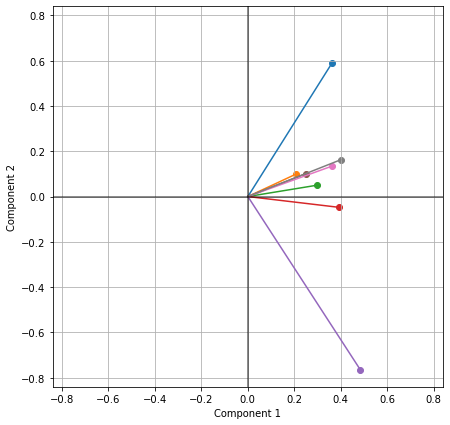

In [275]:
# Biplot
plt.figure(figsize=(7, 7))
pca.biplot2d()
plt.show()

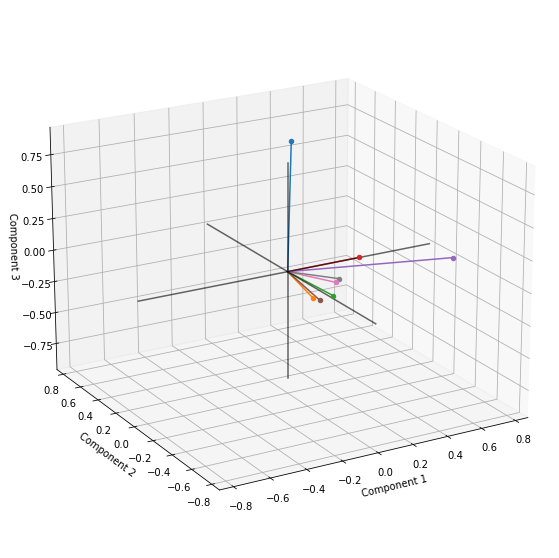

In [276]:
# 3D biplot
plt.figure(figsize=(10, 10))
ax = pca.biplot3d()
ax.view_init(20, -120)
plt.show()

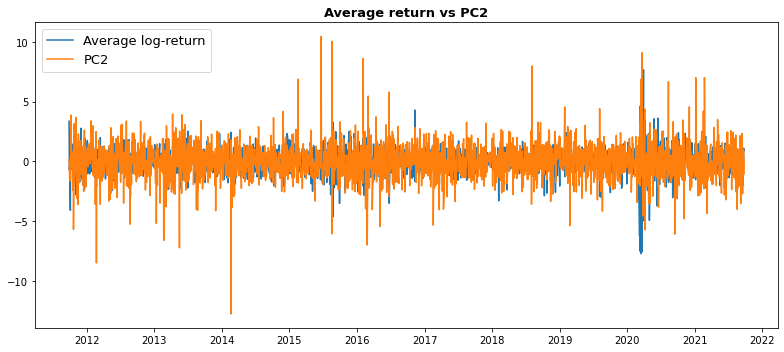

In [277]:
pc = pca.transform(n_comp=8)
plt.figure(figsize=(11, 5))
plt.plot(log_r.index, log_r.mean(axis=1), label='Average log-return')
plt.plot(log_r.index, pc[:,1], label='PC2')
plt.title('Average return vs PC2', fontsize=13, weight='bold')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Answer a)

From the implementation of the Principal Component Analysis, we obtain 8 principal components and their respective weights on each variable (stock).

From the table above and the various PC weights, we can try to understand what each component represents.

The 1st component, PC 1, appears to load equally on each stock and can represent the 'market' factor that explains the general trend of the 8 stocks.

The 2nd component, PC 2, instead, contrasts Seek (SEK) and Computershare (CPU) against the remaining stocks. As both companies are part of the technology sector, we can consider PC 2 as a 'technology' factor. Thus, PC 2 captures the difference in general trends between tech and non-tech stocks.

The 3rd component, PC 3, also appears to be contrasting SEK and CPU (both positive) against the remaining stocks which all load negatively. However, in this case, also Rio Tinto (RIO) loads postively as the tech stocks, even though being part of the Industrial Metals and Mining industry. But the weight magnitude is double the tech stocks' weights.

The 4th component, PC 4, appears to be contrasting Computershare (CPU) against the other stocks. Indeed it loads highly negatively on CPU, whilst positevely or only slightly negatively on the remaining stocks. Thus, PC 4 might be capturing the specific trend of CPU.

In [278]:
tbl_mat = np.vstack([
        pca.eigval,
        pca.prop_var_explained(),
        np.cumsum(pca.prop_var_explained())])
tbl_eigval = pd.DataFrame(tbl_mat.round(4),
    index=['Eigenvalue', '% Variance', 'Cumulative'],
    columns=c_name)
tbl_eigval

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
Eigenvalue,8.2177,2.3483,1.9592,1.6777,1.3119,1.0134,0.6165,0.2974
% Variance,0.4711,0.1346,0.1123,0.0962,0.0752,0.0581,0.0353,0.0170
Cumulative,0.4711,0.6058,0.7181,0.8143,0.8895,0.9476,0.9830,1.0000


### Answer b)

As we can observe from the table above, PC 1, 2, 3, 4, 5 and 6 all have eigenvalues above 1. Thus, if considering the informal method of choosing as many components with egeinvalue greater than 1, we would end up choosing 6 components.

However, it is important to consider the incremental benefit of adding an additional component. Indeed, as observed from the graphs above, PC 5, 6, 7 and 8 only each explains a small percentage of total variance. Additionally, the first 3 components alone already explain 71.81% of total variance.

Therefore, our choice is 3 components. (maybe 4??)

In [279]:
tbl_eigval

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
Eigenvalue,8.2177,2.3483,1.9592,1.6777,1.3119,1.0134,0.6165,0.2974
% Variance,0.4711,0.1346,0.1123,0.0962,0.0752,0.0581,0.0353,0.0170
Cumulative,0.4711,0.6058,0.7181,0.8143,0.8895,0.9476,0.9830,1.0000


### Answer c)

From the able above, it is clear to observe the percentage of total variance explained by each component.

More precisely, PC 1 captures 47.11%, PC 2 captures 13.46%, PC 3 captures 11.23%, PC 4 captures 9.62%, PC 5 captures 7.52%, PC 6 captures 5.81%, PC 7 captures 3.53%, PC 8 captures 1.70%, 

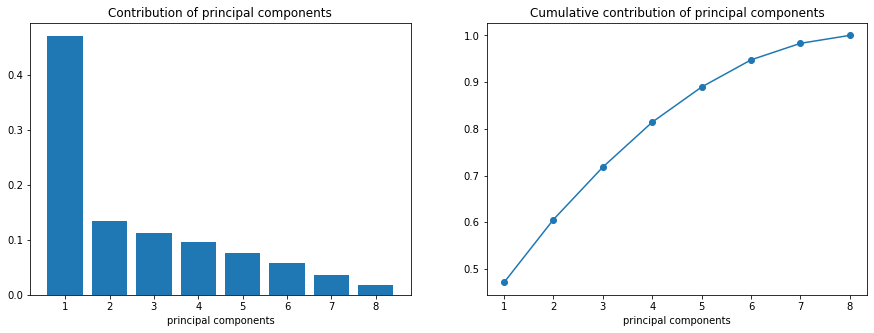

In [280]:
plt.figure(figsize=(15, 5))

number_of_components = len(pca.prop_var_explained())

plt.subplot(1, 2, 1)
plt.bar(np.arange(number_of_components) + 1, pca.prop_var_explained())
plt.title('Contribution of principal components')
plt.xlabel('principal components')

plt.subplot(1, 2, 2)
plt.plot(np.arange(number_of_components) + 1, np.cumsum(pca.prop_var_explained()), 'o-')
plt.title('Cumulative contribution of principal components')
plt.xlabel('principal components');
plt.show()

### Answer d)

As mentioned before and observable from the above tables and graphs, the first 3 components alone explain a significant part of the total variance. Namely, they capture 71.81% of the total variance.

---

## Factor Analysis

In [281]:
# Sample correlation matrix 
log_r.corr()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.000000,0.219045,0.313160,0.325313,0.279959,0.259660,0.403502,0.400347
TLS.AX,0.219045,1.000000,0.432200,0.241640,0.238745,0.347203,0.386753,0.338723
WES.AX,0.313160,0.432200,1.000000,0.380599,0.404946,0.557080,0.563177,0.506858
CPU.AX,0.325313,0.241640,0.380599,1.000000,0.408073,0.278818,0.457882,0.462006
SEK.AX,0.279959,0.238745,0.404946,0.408073,1.000000,0.287734,0.432428,0.412324
WOW.AX,0.259660,0.347203,0.557080,0.278818,0.287734,1.000000,0.449792,0.369972
CBA.AX,0.403502,0.386753,0.563177,0.457882,0.432428,0.449792,1.000000,0.829803
WBC.AX,0.400347,0.338723,0.506858,0.462006,0.412324,0.369972,0.829803,1.000000


In [282]:
'''
Biplot for a given weight matrix
'''
def biplot(weight, labels=None):
    ax = plt.axes()
    for i in range(weight.shape[0]):
        w = weight[i, :]
        if labels is None:
            ax.plot([0, w[0]], [0, w[1]])
        else:
            ax.plot([0, w[0]], [0, w[1]], label=labels[i])
        ax.scatter(w[0], w[1])
    ax.axhline(y=0, color='k', alpha=0.6)
    ax.axvline(x=0, color='k', alpha=0.6)
    lim = np.max(np.abs(weight[:, :2]))
    lim = lim + 0.1 * lim
    ax.axis([-lim, lim, -lim, lim])
    ax.grid(True)
    ax.set_xlabel('Factor 1 loading')
    ax.set_ylabel('Factor 2 loading')
    return ax

'''
3D biplot for a given weight matrix
'''
def biplot3d(weight):
    ax = plt.axes(projection="3d")
    for i in range(weight.shape[0]):
        w = weight[i, :]
        ax.plot([0, w[0]], [0, w[1]], [0, w[2]])
        ax.scatter(w[0], w[1], w[2])
    lim = np.max(np.abs(weight[:, :3]))
    lim = lim + 0.1 * lim
    ax.axis([-lim, lim, -lim, lim])
    ax.set_zbound(lower=-lim, upper=lim)
    ax.plot([-lim, lim], [0, 0], [0, 0], 'k', alpha=0.6)
    ax.plot([0, 0], [-lim, lim], [0, 0], 'k', alpha=0.6)
    ax.plot([0, 0], [0, 0], [-lim, lim], 'k', alpha=0.6)
    ax.grid(True)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    return ax

### i) 1 factor (m=1)

In [283]:
#Fitting the Factor Analysis with m=1
fm1 = Factor(endog=log_r, n_factor=1, method='ml')
result1 = fm1.fit()

In [284]:
# Standardised factor loadings
result1.loadings

array([[0.46218488],
       [0.44021944],
       [0.63972847],
       [0.53246156],
       [0.50107263],
       [0.50681852],
       [0.91790347],
       [0.87496598]])

In [285]:
# Factor loadings (regression coefficients), i.e. rescaled to be on the scale of y (i.e. the returns data).
result1.loadings[:, 0] * log_r.std()

RIO.AX    0.786601
TLS.AX    0.535184
WES.AX    0.778773
CPU.AX    0.864942
SEK.AX    0.953479
WOW.AX    0.639696
CBA.AX    1.174866
WBC.AX    1.266303
dtype: float64

In [286]:
tbl_loading1 = pd.DataFrame({'Factor 1': round(result1.loadings[:,0] * log_r.std(), 4)})
tbl_loading1

,Factor 1
RIO.AX,0.7866
TLS.AX,0.5352
WES.AX,0.7788
CPU.AX,0.8649
SEK.AX,0.9535
WOW.AX,0.6397
CBA.AX,1.1749
WBC.AX,1.2663


In [287]:
result1.uniqueness
ser2 = result1.uniqueness * log_r.var() 
ser = np.sqrt(ser2)
r2 = np.sqrt(result1.communality * log_r.var())     # re-scaled to be for actual data

tbl_r = pd.DataFrame({'Sample STD': log_r.std().round(4),
                      'Communal STD': r2.round(4),
                      'Specific STD' : ser.round(4)})
tbl_r.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample STD,1.7019,1.2157,1.2173,1.6244,1.9029,1.2622,1.2799,1.4473
Communal STD,0.7866,0.5352,0.7788,0.8649,0.9535,0.6397,1.1749,1.2663
Specific STD,1.5092,1.0916,0.9357,1.3750,1.6468,1.0881,0.5079,0.7007


In [288]:
r2 = result1.communality * log_r.var()    # re-scaled to be for actual data
communal_var = result1.communality * log_r.var()

tbl_r = pd.DataFrame({'Sample Variance': log_r.var().round(4),
                      'Communal Variance': communal_var.round(4),
                      'Specific Variance' : ser.round(4)**2})
tbl_r.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Variance,2.896500,1.478000,1.481900,2.638700,3.62090,1.593100,1.638300,2.09460
Communal Variance,0.618700,0.286400,0.606500,0.748100,0.90910,0.409200,1.380300,1.60350
Specific Variance,2.277685,1.191591,0.875534,1.890625,2.71195,1.183962,0.257962,0.49098


In [289]:
#Total data variance captured by FM m=1
total_data_variance = np.sum(log_r.var())
total_communal_variance_1 = np.sum(result1.communality * log_r.var())
Rsq_1 = total_communal_variance_1 / total_data_variance
Rsq_1

0.3762141383153286

### ii) 2 factors (m=2)

In [290]:
#Fitting the Factor Analysis with m=2
fm2 = Factor(endog=log_r, n_factor=2, method='ml')
result2 = fm2.fit()

In [291]:
# Standardised factor loadings
result2.loadings

array([[-0.45732608, -0.06283236],
       [-0.43781005, -0.28695287],
       [-0.65879023, -0.48086763],
       [-0.52875564, -0.08631787],
       [-0.49563663, -0.15729244],
       [-0.50956777, -0.4459024 ],
       [-0.8967087 ,  0.04511492],
       [-0.91353048,  0.20663897]])

In [292]:
# Actual loadings with Factor 1 by (-1)
tbl_loading2 = pd.DataFrame({'Factor 1': round(result2.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result2.loadings[:,1] * log_r.std(), 4)})
tbl_loading2

,Factor 1,Factor 2
RIO.AX,0.7783,-0.1069
TLS.AX,0.5323,-0.3489
WES.AX,0.8020,-0.5854
CPU.AX,0.8589,-0.1402
SEK.AX,0.9431,-0.2993
WOW.AX,0.6432,-0.5628
CBA.AX,1.1477,0.0577
WBC.AX,1.3221,0.2991


In [293]:
ser2_2 = result2.uniqueness * log_r.var() 
ser_2 = np.sqrt(ser2_2)
r2_2 = result2.communality * log_r.var()

tbl_r_2 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=1)' : ser2.round(4),
                        'Specific Var (m=2)' : ser2_2.round(4),
                        'Communal Var (m=1)': r2.round(4),
                        'Communal Var (m=2)': r2_2.round(4)})
tbl_r_2.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=1),2.2778,1.1916,0.8755,1.8906,2.7118,1.1839,0.2579,0.4910
Specific Var (m=2),2.2793,1.0730,0.4961,1.8813,2.6418,0.8627,0.3176,0.2571
Communal Var (m=1),0.6187,0.2864,0.6065,0.7481,0.9091,0.4092,1.3803,1.6035
Communal Var (m=2),0.6172,0.4050,0.9858,0.7574,0.9791,0.7304,1.3206,1.8374


In [294]:
#Total data variance captured by FM m=2
total_data_variance = np.sum(log_r.var())
total_communal_variance_2 = np.sum(result2.communality * log_r.var())
Rsq_2 = total_communal_variance_2 / total_data_variance
Rsq_2

0.4376235471054291

In [295]:
# standardise data and show correlation matrix
x = (log_r - log_r.mean()) / log_r.std()
x.cov()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.000000,0.219045,0.313160,0.325313,0.279959,0.259660,0.403502,0.400347
TLS.AX,0.219045,1.000000,0.432200,0.241640,0.238745,0.347203,0.386753,0.338723
WES.AX,0.313160,0.432200,1.000000,0.380599,0.404946,0.557080,0.563177,0.506858
CPU.AX,0.325313,0.241640,0.380599,1.000000,0.408073,0.278818,0.457882,0.462006
SEK.AX,0.279959,0.238745,0.404946,0.408073,1.000000,0.287734,0.432428,0.412324
WOW.AX,0.259660,0.347203,0.557080,0.278818,0.287734,1.000000,0.449792,0.369972
CBA.AX,0.403502,0.386753,0.563177,0.457882,0.432428,0.449792,1.000000,0.829803
WBC.AX,0.400347,0.338723,0.506858,0.462006,0.412324,0.369972,0.829803,1.000000


In [296]:
# show fitted correlation matrix using factor loadings and uniquenesss for statndardised data
result2.fitted_cov

array([[1.00000014, 0.21825188, 0.331496  , 0.2472373 , 0.23655061,
        0.26105573, 0.4072536 , 0.4047977 ],
       [0.21825188, 0.99999953, 0.42641133, 0.25626369, 0.26213021,
        0.35104686, 0.37964222, 0.34065717],
       [0.331496  , 0.42641133, 1.00000006, 0.38984652, 0.40215741,
        0.5501183 , 0.56904862, 0.50245896],
       [0.2472373 , 0.25626369, 0.38984652, 1.00000032, 0.27564781,
        0.30792618, 0.47024555, 0.46519775],
       [0.23655061, 0.26213021, 0.40215741, 0.27564781, 0.99999987,
        0.32269753, 0.43734544, 0.42027642],
       [0.26105573, 0.35104686, 0.5501183 , 0.30792618, 0.32269753,
        1.00000025, 0.436817  , 0.37336488],
       [0.4072536 , 0.37964222, 0.56904862, 0.47024555, 0.43734544,
        0.436817  , 1.00000042, 0.82849322],
       [0.4047977 , 0.34065717, 0.50245896, 0.46519775, 0.42027642,
        0.37336488, 0.82849322, 1.0000004 ]])

In [297]:
Λ = result2.loadings
Ψ = np.diag(result2.uniqueness)

Λ @ Λ.T + Ψ

array([[1.00000014, 0.21825188, 0.331496  , 0.2472373 , 0.23655061,
        0.26105573, 0.4072536 , 0.4047977 ],
       [0.21825188, 0.99999953, 0.42641133, 0.25626369, 0.26213021,
        0.35104686, 0.37964222, 0.34065717],
       [0.331496  , 0.42641133, 1.00000006, 0.38984652, 0.40215741,
        0.5501183 , 0.56904862, 0.50245896],
       [0.2472373 , 0.25626369, 0.38984652, 1.00000032, 0.27564781,
        0.30792618, 0.47024555, 0.46519775],
       [0.23655061, 0.26213021, 0.40215741, 0.27564781, 0.99999987,
        0.32269753, 0.43734544, 0.42027642],
       [0.26105573, 0.35104686, 0.5501183 , 0.30792618, 0.32269753,
        1.00000025, 0.436817  , 0.37336488],
       [0.4072536 , 0.37964222, 0.56904862, 0.47024555, 0.43734544,
        0.436817  , 1.00000042, 0.82849322],
       [0.4047977 , 0.34065717, 0.50245896, 0.46519775, 0.42027642,
        0.37336488, 0.82849322, 1.0000004 ]])

In [298]:
ll_2 = np.log(np.linalg.det(x.cov())) - np.log(np.linalg.det(result2.fitted_cov))

In [299]:
m = 2
T = log_r.shape[0]
n = log_r.shape[1]
lr_2 = -(T - 1 - (2 * n + 5) / 6 - 2 * m / 3) * ll_2
df_2 = 0.5 * ((n - m) **2 - n - m )
print(lr_2)
print(df_2)

151.39931202424413
13.0


In [300]:
# p-value of the test
stats.chi2.sf(lr_2, df_2)

1.0768192902684148e-25

### iii) 3 factors (m=3)

In [301]:
fm3 = Factor(endog=log_r, n_factor=3, method='ml')
result3 = fm3.fit()

In [302]:
result3.loadings

array([[-0.46088738, -0.06577492,  0.14638041],
       [-0.43945603, -0.27898013, -0.07522118],
       [-0.66063925, -0.46455258, -0.07039955],
       [-0.54551006, -0.11332958,  0.4235134 ],
       [-0.50457425, -0.17365462,  0.26979743],
       [-0.51350661, -0.4465834 , -0.1320739 ],
       [-0.89775102,  0.05833903, -0.05583145],
       [-0.90889336,  0.21392261, -0.02442379]])

In [303]:
# Actual loadings with Factor 1 by (-1)
tbl_loading3 = pd.DataFrame({'Factor 1': round(result3.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result3.loadings[:,1] * log_r.std(), 4),
                             'Factor 3': round(result3.loadings[:,2] * log_r.std(), 4)})
tbl_loading3

,Factor 1,Factor 2,Factor 3
RIO.AX,0.7844,-0.1119,0.2491
TLS.AX,0.5343,-0.3392,-0.0914
WES.AX,0.8042,-0.5655,-0.0857
CPU.AX,0.8861,-0.1841,0.6880
SEK.AX,0.9601,-0.3304,0.5134
WOW.AX,0.6481,-0.5637,-0.1667
CBA.AX,1.1491,0.0747,-0.0715
WBC.AX,1.3154,0.3096,-0.0353


In [304]:
ser2_3 = result3.uniqueness * log_r.var() 
ser_3 = np.sqrt(ser2_3)
r2_3 = result3.communality * log_r.var()


tbl_r_3 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=2)' : ser2_2.round(4),
                        'Specific Var (m=3)' : ser2_3.round(4),
                        'Communal Var (m=2)': r2_2.round(4),
                        'Communal Var (m=3)': r2_3.round(4)})
tbl_r_3.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=2),2.2793,1.0730,0.4961,1.8813,2.6418,0.8627,0.3176,0.2571
Specific Var (m=3),2.2067,1.0692,0.5080,1.3463,2.3263,0.8275,0.3072,0.2672
Communal Var (m=2),0.6172,0.4050,0.9858,0.7574,0.9791,0.7304,1.3206,1.8374
Communal Var (m=3),0.6899,0.4088,0.9739,1.2924,1.2946,0.7656,1.3310,1.8274


In [305]:
#Total data variance captured by FM m=3
total_data_variance = np.sum(log_r.var())
total_communal_variance_3 = np.sum(result3.communality * log_r.var())
Rsq_3 = total_communal_variance_3 / total_data_variance
Rsq_3

0.49212890998734493

In [306]:
ll_3 = np.log(np.linalg.det(x.cov())) - np.log(np.linalg.det(result3.fitted_cov))

In [307]:
m = 3
T = log_r.shape[0]
n = log_r.shape[1]
lr_3 = -(T - 1 - (2 * n + 5) / 6 - 2 * m / 3) * ll_2
df_3 = 0.5 * ((n - m) **2 - n - m )
print(lr_3)
print(df_3)

151.3593412468633
7.0


In [308]:
# p-value of the test
stats.chi2.sf(lr_3, df_3)

2.1037789818461465e-29

### iv) 4 factors (m=4)

In [309]:
fm4 = Factor(endog=log_r, n_factor=4, method='ml')
result4 = fm4.fit(maxiter = 5000, tol = 1e-7, opt_method = 'tnc')

In [310]:
result4.loadings

array([[-0.32860209,  0.29392786, -0.22516244,  0.0190589 ],
       [-0.44085981,  0.13865626, -0.1284165 ,  0.20702537],
       [-0.99667055, -0.04659775,  0.00263879, -0.00165131],
       [-0.39832712,  0.33252933, -0.43735019, -0.18863197],
       [-0.41886173,  0.25296324, -0.32339104, -0.08312992],
       [-0.56454655,  0.09931786, -0.17048577,  0.29564828],
       [-0.59553164,  0.64120816, -0.07778556,  0.12492785],
       [-0.54574415,  0.79929725,  0.0603073 , -0.0247869 ]])

In [311]:
# Actual loadings with Factor 1 by (-1)
tbl_loading4 = pd.DataFrame({'Factor 1': round(result4.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result4.loadings[:,1] * log_r.std(), 4),
                             'Factor 3': round(result4.loadings[:,2] * log_r.std(), 4),
                             'Factor 4': round(result4.loadings[:,3] * log_r.std(), 4)})
tbl_loading4

,Factor 1,Factor 2,Factor 3,Factor 4
RIO.AX,0.5593,0.5002,-0.3832,0.0324
TLS.AX,0.5360,0.1686,-0.1561,0.2517
WES.AX,1.2133,-0.0567,0.0032,-0.0020
CPU.AX,0.6471,0.5402,-0.7104,-0.3064
SEK.AX,0.7970,0.4814,-0.6154,-0.1582
WOW.AX,0.7126,0.1254,-0.2152,0.3732
CBA.AX,0.7622,0.8207,-0.0996,0.1599
WBC.AX,0.7898,1.1568,0.0873,-0.0359


In [312]:
ser2_4 = result4.uniqueness * log_r.var() 
ser_4 = np.sqrt(ser2_4)
r2_4 = result4.communality * log_r.var()


tbl_r_4 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=3)' : ser2_3.round(4),
                        'Specific Var (m=4)' : ser2_4.round(4),
                        'Communal Var (m=3)': r2_3.round(4),
                        'Communal Var (m=4)': r2_4.round(4)})
tbl_r_4.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=3),2.2067,1.0692,0.5080,1.3463,2.3263,0.8275,0.3072,0.2672
Specific Var (m=4),2.1856,1.0745,0.0069,1.3297,2.3501,0.8840,0.3482,0.1234
Communal Var (m=3),0.6899,0.4088,0.9739,1.2924,1.2946,0.7656,1.3310,1.8274
Communal Var (m=4),0.7109,0.4035,1.4750,1.3090,1.2708,0.7091,1.2901,1.9712


In [313]:
ll_4 = np.log(np.linalg.det(x.cov())) - np.log(np.linalg.det(result4.fitted_cov))

In [314]:
m = 4
T = log_r.shape[0]
n = log_r.shape[1]
lr_4 = -(T - 1 - (2 * n + 5) / 6 - 2 * m / 3) * ll_2
df_4 = 0.5 * ((n - m) **2 - n - m )
print(lr_4)
print(df_4)

151.31937046948246
2.0


In [315]:
# p-value of the test
stats.chi2.sf(lr_4, df_4)

1.384892935914196e-33

In [316]:
#Total data variance captured by FM m=4
total_data_variance = np.sum(log_r.var())
total_communal_variance_4 = np.sum(result4.communality * log_r.var())
Rsq_4 = total_communal_variance_4 / total_data_variance
Rsq_4

0.5240050882536553

---
## Answers - Factor Analysis

### Answer e)

In [317]:
tbl_loading2

,Factor 1,Factor 2
RIO.AX,0.7783,-0.1069
TLS.AX,0.5323,-0.3489
WES.AX,0.8020,-0.5854
CPU.AX,0.8589,-0.1402
SEK.AX,0.9431,-0.2993
WOW.AX,0.6432,-0.5628
CBA.AX,1.1477,0.0577
WBC.AX,1.3221,0.2991


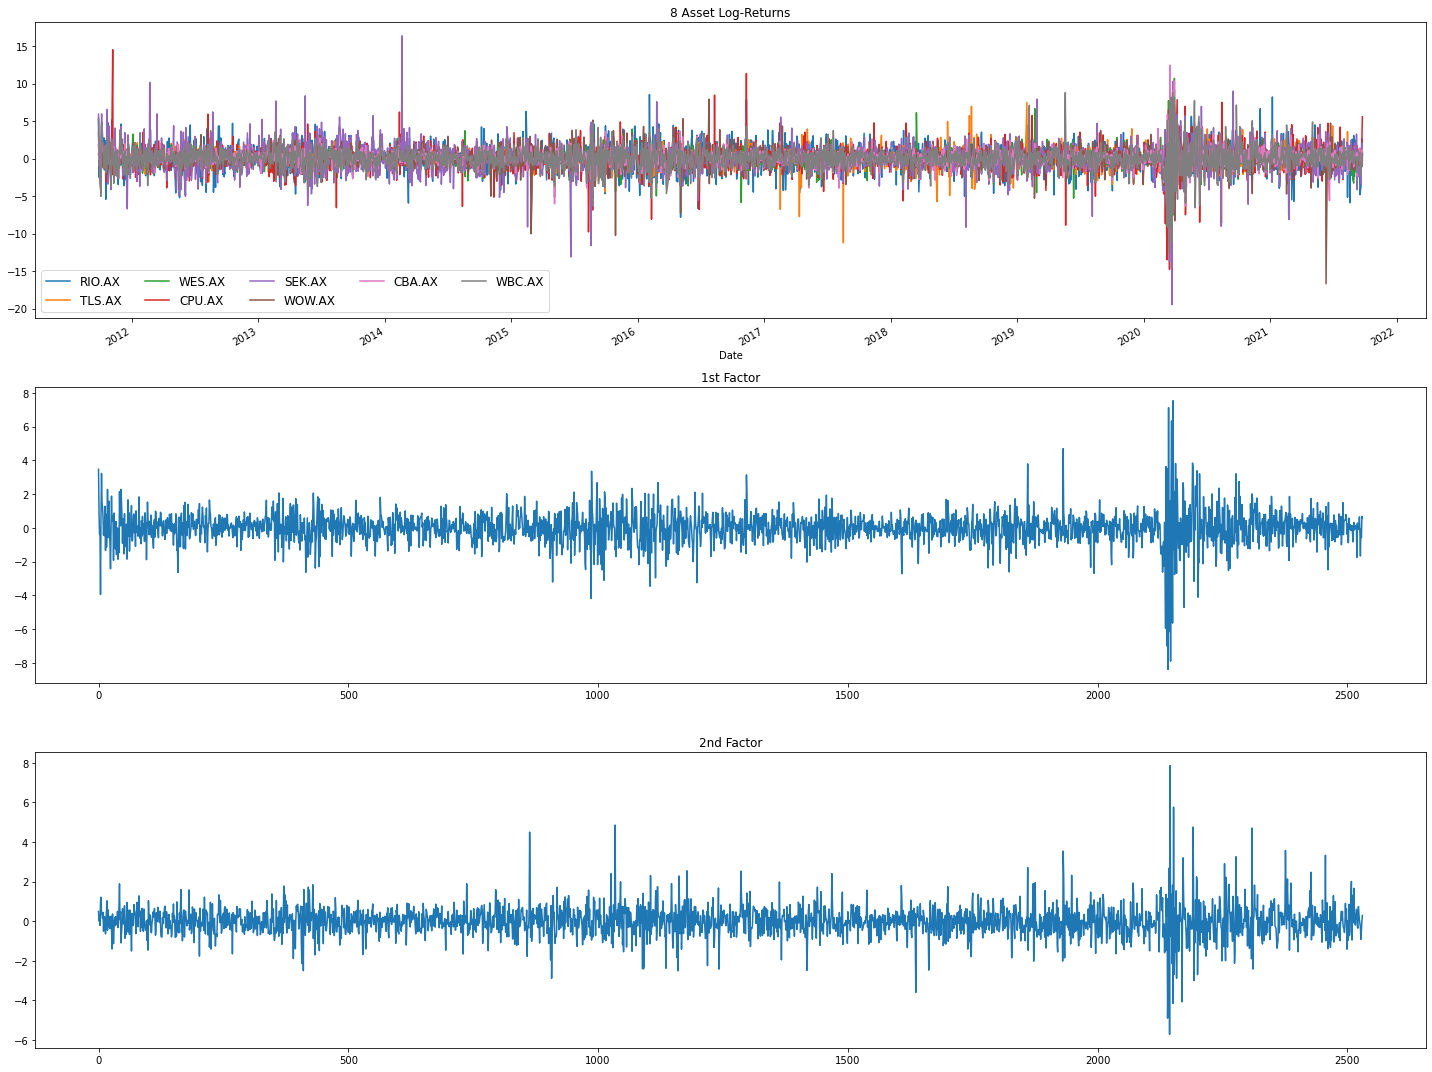

In [318]:
score_2 = result2.factor_scoring(method='regression', transform=True)
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
log_r.plot(ax=ax[0])
ax[0].set_title('8 Asset Log-Returns')
ax[0].legend(loc='best', ncol=5, fontsize=12)
ax[1].plot(score_2[:,0] * (-1))
ax[1].set_title('1st Factor')
ax[2].plot(score_2[:,1])
ax[2].set_title('2nd Factor')
plt.tight_layout()
plt.show()

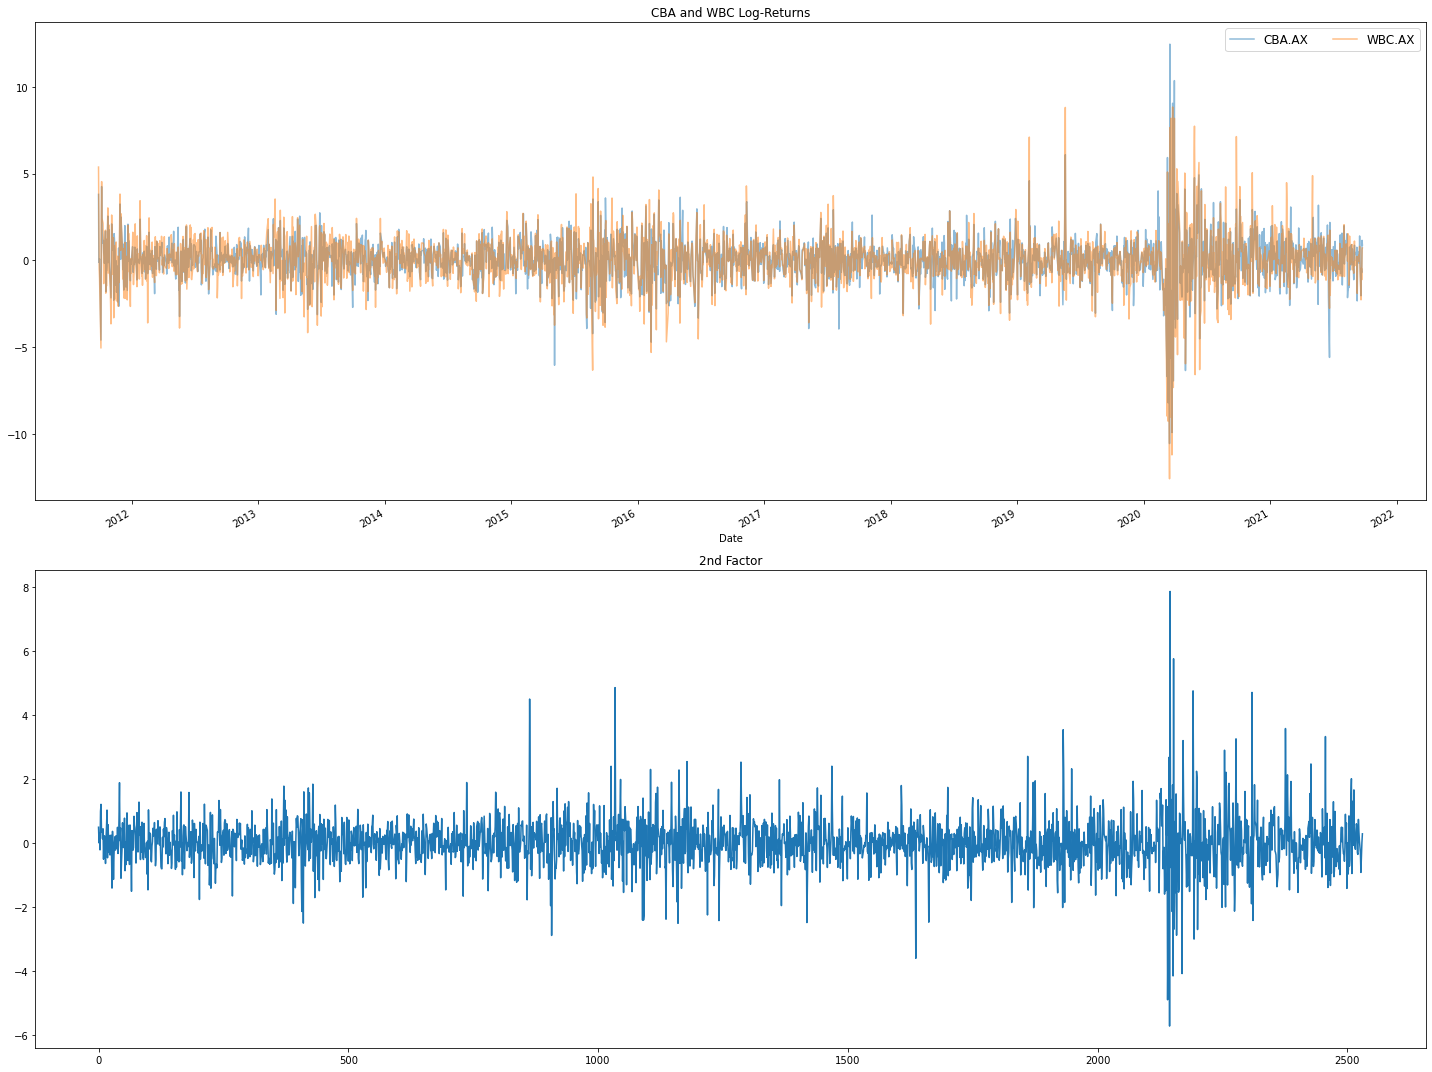

In [319]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
banking_log = log_r[['CBA.AX','WBC.AX']]
banking_log.plot(ax=ax[0], alpha = 0.5)
ax[0].set_title('CBA and WBC Log-Returns')
ax[0].legend(loc='best', ncol=5, fontsize=12)
ax[1].plot(score_2[:,1])
ax[1].set_title('2nd Factor')
plt.tight_layout()
plt.show()

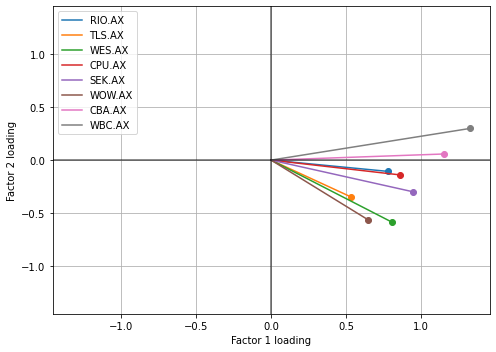

In [320]:
plt.figure(figsize=(7, 5))
biplot(tbl_loading2.values, labels=log_r.columns)
plt.tight_layout()
plt.legend()
plt.show()

After having performed a statistical factor analysis on the assets log-returns with different number of factors, we proceed to analyse the case with m=2 below.

Above we have reported the table showing Factor 1 and 2 loadings for each variable. Particularly, we chose to make the 1st factor loading all positive, by multiplying it by (-1), while also multiplying the 1st factor by (-1), since $\beta f = -\beta (-f) = (-1)^2 \beta f = \beta f$. This does not change the maths at all, it just gives a more intuitive and suitable interpretation of the factor in this financial context.    

Concerning the interpretation of the 2 factors, it seems that both of them have useful interpretations.

Factor 1 loads positevily on all the stocks. Loading more heavily on WBC and CBA and less heavily on TLS. However, as for the order of magnitude being not too different, Factor 1 appears to be a 'market' factor as it also captures the general trend of the stocks as observed in the above line chart. However, it might drive banking stocks more than the other ones.

Factor 2, instead, loads positively on the banking stocks, WBC and CBA, and negatively on the remaining ones. Indeed, it appears to contrast the banking stocks against the rest.
Particularly, Factor 2 seems to better drive the trend of banking stocks (as shown in the above line chart) and thus it is a more banking-specific factor.

### Answer f)

In [321]:
# standardise data and show correlation matrix
x.cov()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.000000,0.219045,0.313160,0.325313,0.279959,0.259660,0.403502,0.400347
TLS.AX,0.219045,1.000000,0.432200,0.241640,0.238745,0.347203,0.386753,0.338723
WES.AX,0.313160,0.432200,1.000000,0.380599,0.404946,0.557080,0.563177,0.506858
CPU.AX,0.325313,0.241640,0.380599,1.000000,0.408073,0.278818,0.457882,0.462006
SEK.AX,0.279959,0.238745,0.404946,0.408073,1.000000,0.287734,0.432428,0.412324
WOW.AX,0.259660,0.347203,0.557080,0.278818,0.287734,1.000000,0.449792,0.369972
CBA.AX,0.403502,0.386753,0.563177,0.457882,0.432428,0.449792,1.000000,0.829803
WBC.AX,0.400347,0.338723,0.506858,0.462006,0.412324,0.369972,0.829803,1.000000


In [322]:
# show fitted correlation matrix using factor loadings and uniquenesss for statndardised data
result2.fitted_cov

array([[1.00000014, 0.21825188, 0.331496  , 0.2472373 , 0.23655061,
        0.26105573, 0.4072536 , 0.4047977 ],
       [0.21825188, 0.99999953, 0.42641133, 0.25626369, 0.26213021,
        0.35104686, 0.37964222, 0.34065717],
       [0.331496  , 0.42641133, 1.00000006, 0.38984652, 0.40215741,
        0.5501183 , 0.56904862, 0.50245896],
       [0.2472373 , 0.25626369, 0.38984652, 1.00000032, 0.27564781,
        0.30792618, 0.47024555, 0.46519775],
       [0.23655061, 0.26213021, 0.40215741, 0.27564781, 0.99999987,
        0.32269753, 0.43734544, 0.42027642],
       [0.26105573, 0.35104686, 0.5501183 , 0.30792618, 0.32269753,
        1.00000025, 0.436817  , 0.37336488],
       [0.4072536 , 0.37964222, 0.56904862, 0.47024555, 0.43734544,
        0.436817  , 1.00000042, 0.82849322],
       [0.4047977 , 0.34065717, 0.50245896, 0.46519775, 0.42027642,
        0.37336488, 0.82849322, 1.0000004 ]])

In [323]:
Λ @ Λ.T + Ψ

array([[1.00000014, 0.21825188, 0.331496  , 0.2472373 , 0.23655061,
        0.26105573, 0.4072536 , 0.4047977 ],
       [0.21825188, 0.99999953, 0.42641133, 0.25626369, 0.26213021,
        0.35104686, 0.37964222, 0.34065717],
       [0.331496  , 0.42641133, 1.00000006, 0.38984652, 0.40215741,
        0.5501183 , 0.56904862, 0.50245896],
       [0.2472373 , 0.25626369, 0.38984652, 1.00000032, 0.27564781,
        0.30792618, 0.47024555, 0.46519775],
       [0.23655061, 0.26213021, 0.40215741, 0.27564781, 0.99999987,
        0.32269753, 0.43734544, 0.42027642],
       [0.26105573, 0.35104686, 0.5501183 , 0.30792618, 0.32269753,
        1.00000025, 0.436817  , 0.37336488],
       [0.4072536 , 0.37964222, 0.56904862, 0.47024555, 0.43734544,
        0.436817  , 1.00000042, 0.82849322],
       [0.4047977 , 0.34065717, 0.50245896, 0.46519775, 0.42027642,
        0.37336488, 0.82849322, 1.0000004 ]])

In [324]:
print(lr_2)
print(df_2)

151.39931202424413
13.0


In [325]:
# p-value of the test
stats.chi2.sf(lr_2, df_2)

1.0768192902684148e-25

There is a statistical test comparing the sample covariance matrix to the var- cov matrix estimated using the loadings and specific variances, under the ML estimation method.

The test statistic is:
$$LR(m) = -[T - 1 - \frac{2n + 5}{6} - \frac{2m}{3}]\left(\ln\lvert \hat{\Sigma} \rvert - \ln \lvert\hat{\beta}\hat{\beta}'+\hat{\Psi}\rvert\right) $$
which, under a null hypothesis that the number of factors equals m, follows a chi-squared distribution with $0.5[(n − m)^2 − n − m]$ degrees of freedom.

Where,

H0: $m=2$ factor model is able to model the 8 log-return series.

H1: more factors are needed to model the 8 log-return series

Having performed such test above and looking at the p-value calculated, we can say that H0 is rejected since the p-value is very small (<<<< 0.05). Therefore, there is not enough evidence to conclude that the $m=2$ Factor Model is able to model the 8 log-return series.
More factors are needed.

### Answer g)

In [326]:
print('The total percentage variation exlpained by:' )
print('m=1 Factor Model: {:.2f}%'.format(Rsq_1*100))
print('m=2 Factor Model: {:.2f}%'.format(Rsq_2*100))
print('m=3 Factor Model: {:.2f}%'.format(Rsq_3*100))
print('m=4 Factor Model: {:.2f}%'.format(Rsq_4*100))

The total percentage variation exlpained by:
m=1 Factor Model: 37.62%
m=2 Factor Model: 43.76%
m=3 Factor Model: 49.21%
m=4 Factor Model: 52.40%


In [327]:
tbl_loading3

,Factor 1,Factor 2,Factor 3
RIO.AX,0.7844,-0.1119,0.2491
TLS.AX,0.5343,-0.3392,-0.0914
WES.AX,0.8042,-0.5655,-0.0857
CPU.AX,0.8861,-0.1841,0.6880
SEK.AX,0.9601,-0.3304,0.5134
WOW.AX,0.6481,-0.5637,-0.1667
CBA.AX,1.1491,0.0747,-0.0715
WBC.AX,1.3154,0.3096,-0.0353


In the previuos analyses we compared the sample covariance matrix to the var-cov matrix estimated using the loadings and specific variances, under the ML estimation method, for each factor model (i.e. m=1,2,3 and 4).
In all the 4 cases, the p-value found is very small and thus we rejected the null hypothesis for which such model was able to model the 8 log-return series.

Therefore, these findings do not help us in choosing the number, m, of factors tu employ.

However, we can resort to observe the total percentage of variation explained by each model (i.e. model $R^2$).

In particular, it appears that there is a greater incremental benefit in employing 1 additional factor from m=1 to m=2 and from m=2 to m=3, compared to m=3 to m=4. 
Indeed, the m=3 Factor Model manages to explain almost 50% of the total variance (49.21%). Only, 3.19% less variance explained than m=4 Factor Model.

Therefore, considering that in factor analysis it is key to keep the number of factors substantially lower than the total number of variables available, we choose 3 factors. Namely, we choose to employ the m=3 Factor Model.

Indeed, Factor 3 also seems to have a useful interpretation as it contrasts SEK and CPU against the other stocks. Thus, it seems to represent a technology-specific factor that drives tech stocks more. However, it also loads positively on Rio Tinto, which is an oil and mining company. 

### Answer h)

In [328]:
#Total data variance captured by FM m=2
total_data_variance = np.sum(log_r.var())
total_communal_variance_2 = np.sum(result2.communality * log_r.var())
total_communal_variance_2 / total_data_variance

0.4376235471054291

The 2 Factor model captures 43.76% of the total variance.

### Answer i)

In [329]:
tbl_r_3 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=3)' : ser2_3.round(4),
                        'Communal Var (m=3)': r2_3.round(4)})
tbl_r_3.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=3),2.2067,1.0692,0.5080,1.3463,2.3263,0.8275,0.3072,0.2672
Communal Var (m=3),0.6899,0.4088,0.9739,1.2924,1.2946,0.7656,1.3310,1.8274


Considering the 3 Factor model, the Adjusted-$R^2$ of Computershare (asset 4/CPU) is 1.2924.

### Answer j)

In [330]:
r2 = result1.communality * log_r.var()    # re-scaled to be for actual data
communal_var = result1.communality * log_r.var()

tbl_r = pd.DataFrame({'Sample Var': log_r.var().round(4),
                      'Specific Var (m=1)' : ser.round(4)**2,
                      'Communal Var (m=1)': communal_var.round(4),
                      })
tbl_r.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.896500,1.478000,1.481900,2.638700,3.62090,1.593100,1.638300,2.09460
Specific Var (m=1),2.277685,1.191591,0.875534,1.890625,2.71195,1.183962,0.257962,0.49098
Communal Var (m=1),0.618700,0.286400,0.606500,0.748100,0.90910,0.409200,1.380300,1.60350


Considering the 1 Factor model, the specificity or uniqueness of Telstra (asset 2/TLS) is 1.192.

## Question 2 - Time Series models and Forecasting

In [10]:
# Selecting and transformation asset 2,3 and 4 into Log Returns
assets = data1.iloc[:, 0:4]
log_a = np.log(assets).diff() * 100
log_a

,RIO.AX,TLS.AX,WES.AX,CPU.AX
Date,,,,
2011-09-26,NaN,NaN,NaN,NaN
2011-09-27,5.210688,0.655750,3.483130,1.871724
2011-09-28,0.988479,0.975614,1.040520,0.922870
2011-09-29,-2.529770,0.000000,-0.692494,-0.790514
2011-09-30,-1.046322,0.323089,-0.221343,-1.197638
...,...,...,...,...
2021-09-20,-3.669764,-1.025649,-0.665613,-2.247279
2021-09-21,0.492278,1.280426,0.857469,1.402887
2021-09-22,2.639598,0.507615,-0.279183,-1.096237


In [11]:
# Removing first observation due to NaN
log_c = log_a.iloc[1:, ]
log_c

,RIO.AX,TLS.AX,WES.AX,CPU.AX
Date,,,,
2011-09-27,5.210688,0.655750,3.483130,1.871724
2011-09-28,0.988479,0.975614,1.040520,0.922870
2011-09-29,-2.529770,0.000000,-0.692494,-0.790514
2011-09-30,-1.046322,0.323089,-0.221343,-1.197638
2011-10-04,-4.636567,-3.278966,-5.031071,-4.238481
...,...,...,...,...
2021-09-20,-3.669764,-1.025649,-0.665613,-2.247279
2021-09-21,0.492278,1.280426,0.857469,1.402887
2021-09-22,2.639598,0.507615,-0.279183,-1.096237


## i) Forecasting 

In [12]:
#Forecast Period
periods = len(log_c)
window_length = 2000
n_fore = periods - window_length
n_fore

531

### a) Telstra - TLS.AX

In [13]:
#TLS Forecasts
target_index = 1
rio_index = 0

fnaive_tls = np.empty(n_fore)
f15day_tls = np.empty(n_fore)
farma_tls = np.empty(n_fore)
freg1_tls = np.empty(n_fore)

for i in tqdm(range(n_fore)):
    windowed_rio_data = log_c.iloc[i : i + window_length, rio_index].values
    windowed_target_data = log_c.iloc[i : i + window_length, target_index].values
    
    forecast_target_data = log_c.iloc[(i + 1): (i + window_length + 1), target_index].values
    rio_new = log_c.iloc[(i + window_length - 1), rio_index]
    
    # Naive
    fnaive_tls[i] = windowed_target_data[-1]
    
    # 15 Day
    f15day_tls[i] = np.mean(windowed_target_data[-15:])
    
    # ARMA
    arma11 = ARIMA(windowed_target_data, order=(1, 0, 1)).fit()
    farma_tls[i] = arma11.forecast(step=1)
    
    # Reg
    reg_tls = ARIMA(windowed_target_data, exog=windowed_rio_data, order=(0, 0, 0)).fit() 

    freg1_tls[i] = reg_tls.forecast(exog=rio_new, step=1)

  0%|          | 0/531 [00:00<?, ?it/s]

In [14]:
favg_tls = (f15day_tls + farma_tls + freg1_tls)/3

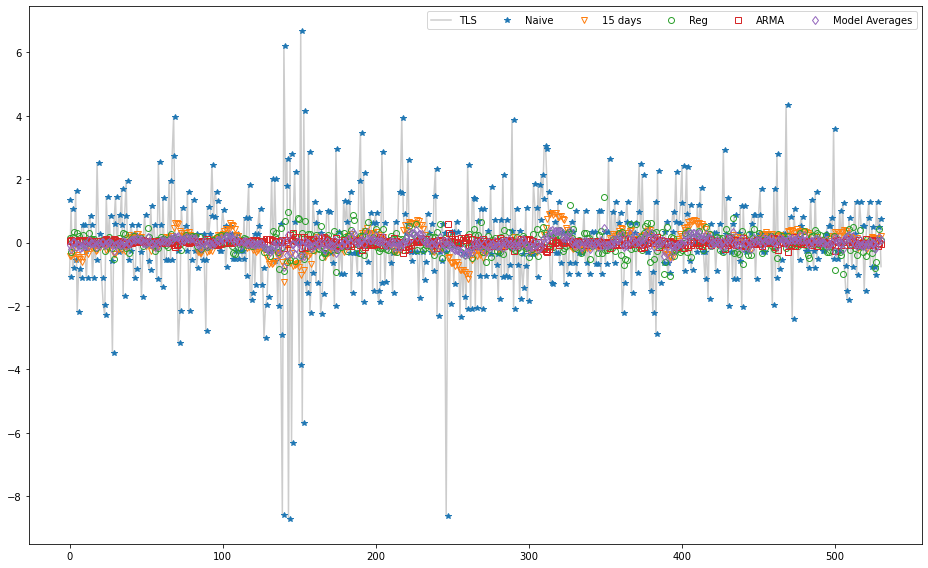

In [15]:
plt.figure(figsize=(13,8))
plt.plot(log_c.iloc[window_length:window_length + n_fore, target_index].values, 'k-', alpha=0.2, label='TLS')
plt.plot(fnaive_tls, '*', label='Naive')
plt.plot(f15day_tls, 'v', mfc='none', label='15 days')
plt.plot(freg1_tls, 'o', mfc='none', label='Reg')
plt.plot(farma_tls, 's', mfc='none', label='ARMA')
plt.plot(favg_tls, 'd', mfc='none', label='Model Averages')
plt.legend(fontsize=10, ncol=8)
plt.tight_layout()
plt.show()

### b) Wesfarmers - WES.AX

In [16]:
#WES Forecasts
target_index = 2
rio_index = 0

fnaive_wes = np.empty(n_fore)
f15day_wes = np.empty(n_fore)
farma_wes = np.empty(n_fore)
freg1_wes = np.empty(n_fore)

for i in tqdm(range(n_fore)):
    windowed_rio_data = log_c.iloc[i : i + window_length, rio_index].values
    windowed_target_data = log_c.iloc[i : i + window_length, target_index].values
    
    forecast_target_data = log_c.iloc[(i + 1): (i + window_length + 1), target_index].values
    rio_new = log_c.iloc[(i + window_length - 1), rio_index]
    
    # Naive
    fnaive_wes[i] = windowed_target_data[-1]
    
    # 15 Day
    f15day_wes[i] = np.mean(windowed_target_data[-15:])
    
    # ARMA
    arma11 = ARIMA(windowed_target_data, order=(1, 0, 1)).fit()
    farma_wes[i] = arma11.forecast(step=1)
    
    # Reg
    reg_wes = ARIMA(windowed_target_data, exog=windowed_rio_data, order=(0, 0, 0)).fit() 

    freg1_wes[i] = reg_wes.forecast(exog=rio_new, step=1)

  0%|          | 0/531 [00:00<?, ?it/s]

In [25]:
favg_wes = (f15day_wes + farma_wes + freg1_wes)/3

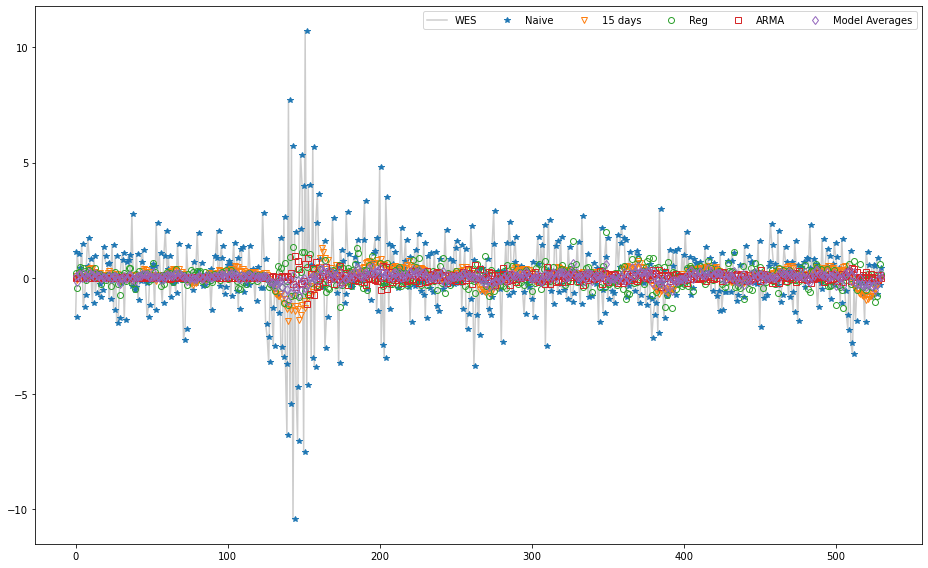

In [15]:
plt.figure(figsize=(13,8))
plt.plot(log_c.iloc[window_length:window_length + n_fore, target_index].values, 'k-', alpha=0.2, label='WES')
plt.plot(fnaive_wes, '*', label='Naive')
plt.plot(f15day_wes, 'v', mfc='none', label='15 days')
plt.plot(freg1_wes, 'o', mfc='none', label='Reg')
plt.plot(farma_wes, 's', mfc='none', label='ARMA')
plt.plot(favg_wes, 'd', mfc='none', label='Model Averages')
plt.legend(fontsize=10, ncol=8)
plt.tight_layout()
plt.show()

### c) Computershare - CPU.AX

In [26]:
#CPU Forecasts
target_index = 3
rio_index = 0

fnaive_cpu = np.empty(n_fore)
f15day_cpu = np.empty(n_fore)
farma_cpu = np.empty(n_fore)
freg1_cpu = np.empty(n_fore)

for i in tqdm(range(n_fore)):
    windowed_rio_data = log_c.iloc[i : i + window_length, rio_index].values
    windowed_target_data = log_c.iloc[i : i + window_length, target_index].values
    
    forecast_target_data = log_c.iloc[(i + 1): (i + window_length + 1), target_index].values
    rio_new = log_c.iloc[(i + window_length - 1), rio_index]
    
    # Naive
    fnaive_cpu[i] = windowed_target_data[-1]
    
    # 15 Day
    f15day_cpu[i] = np.mean(windowed_target_data[-15:])
    
    # ARMA
    arma11 = ARIMA(windowed_target_data, order=(1, 0, 1)).fit()
    farma_cpu[i] = arma11.forecast(step=1)
    
    # Reg
    reg_cpu = ARIMA(windowed_target_data, exog=windowed_rio_data, order=(0, 0, 0)).fit() 

    freg1_cpu[i] = reg_cpu.forecast(exog=rio_new, step=1)

  0%|          | 0/531 [00:00<?, ?it/s]

In [27]:
favg_cpu = (f15day_cpu + farma_cpu + freg1_cpu)/3

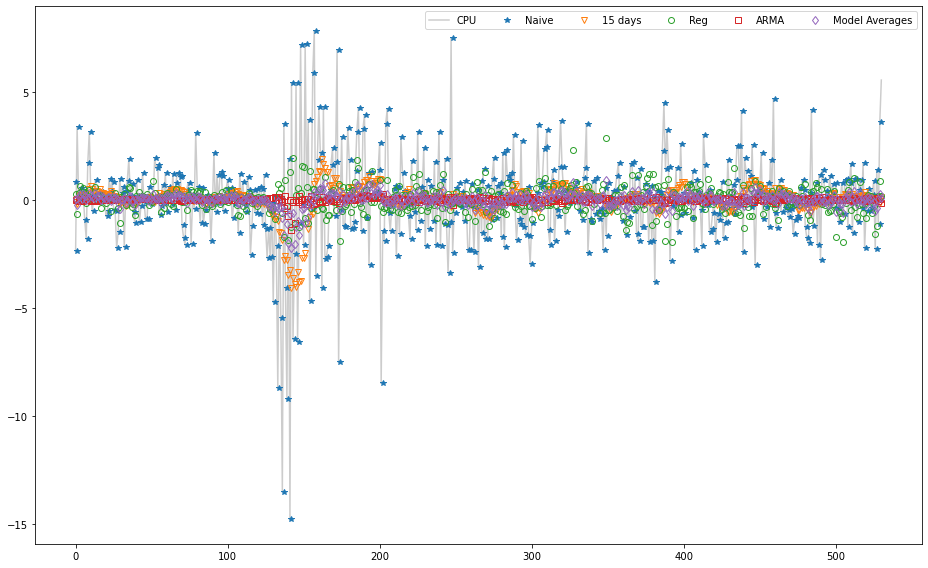

In [18]:
plt.figure(figsize=(13,8))
plt.plot(log_c.iloc[window_length:window_length + n_fore, target_index].values, 'k-', alpha=0.2, label='CPU')
plt.plot(fnaive_cpu, '*', label='Naive')
plt.plot(f15day_cpu, 'v', mfc='none', label='15 days')
plt.plot(freg1_cpu, 'o', mfc='none', label='Reg')
plt.plot(farma_cpu, 's', mfc='none', label='ARMA')
plt.plot(favg_cpu, 'd', mfc='none', label='Model Averages')
plt.legend(fontsize=10, ncol=8)
plt.tight_layout()
plt.show()

## ii) Dynamic Portfolio Weights

In [37]:
# Selecting and transformation asset 2,3 and 4 into Log Returns
r = log_c.iloc[:, 1:4]
r

,TLS.AX,WES.AX,CPU.AX
Date,,,
2011-09-27,0.655750,3.483130,1.871724
2011-09-28,0.975614,1.040520,0.922870
2011-09-29,0.000000,-0.692494,-0.790514
2011-09-30,0.323089,-0.221343,-1.197638
2011-10-04,-3.278966,-5.031071,-4.238481
...,...,...,...
2021-09-20,-1.025649,-0.665613,-2.247279
2021-09-21,1.280426,0.857469,1.402887
2021-09-22,0.507615,-0.279183,-1.096237


### a) Strategy 1 Equal weights

In [38]:
r_fore = r.iloc[-n_fore:, :]
r_eq_wt = np.mean(r_fore, axis=1)
mn_eq_wt = np.mean(r_eq_wt)
sd_eq_wt = np.std(r_eq_wt, ddof=1)
print(mn_eq_wt)
print(sd_eq_wt)

0.048913248148344815
1.407881325435105


### b) Strategy 2 Weight proportional to forecast return for each asset

In [30]:
#Strategy 2 Weight proportional to forecast return for each asset

f_tls = np.vstack([fnaive_tls, f15day_tls, farma_tls, freg1_tls,favg_tls]).T
f_wes = np.vstack([fnaive_wes, f15day_wes, farma_wes, freg1_wes,favg_wes]).T
f_cpu = np.vstack([fnaive_cpu, f15day_cpu, farma_cpu, freg1_cpu,favg_cpu]).T

f_all = np.empty((n_fore, 5, 3))
f_all[:, :, 0] = f_tls
f_all[:, :, 1] = f_wes
f_all[:, :, 2] = f_cpu

In [40]:
r_prop_ret = np.empty((n_fore, 5))
w = np.empty((n_fore, 3))
for i in range(5):
    a_sum = np.sum(f_all[:, i, :], axis=1)
    w = f_all[:, i, :] / a_sum.reshape(-1, 1)
    a_prop_ret[:, i] = np.sum(r_fore.values * w, axis=1)

    
    mn_prop_ret = np.mean(a_prop_ret, axis=0)
sd_prop_ret = np.std(a_prop_ret, axis=0, ddof=1)
print(mn_prop_ret)
print(sd_prop_ret)

[-1.36868644  3.04700767  0.19793366 -0.12619723 -0.28910234]
[43.09708326 52.83942742  5.62426741  3.70133013  4.4168378 ]


### c) Strategy 3 Weight inversely proportional to their sample standard deviation of the last 22 in-sample asset returns

In [41]:
#Strategy 3 Weight inversely proportional to their sample standard deviation of the last 22 in-sample asset returns

std22 = np.empty((n_fore, 3))
for i in range(n_fore):
    std22[i,:]=np.std(r.iloc[(2000+i-22):(2000+i)],axis=0,ddof=1)

t1 = 1 / std22
t2 = np.sum(t1, axis=1)
w = t1 / t2.reshape(-1,1)
r_invp_ret = np.sum(r_fore.values * w, axis = 1)

mn_invp_ret = np.mean(r_invp_ret, axis=0)
sd_invp_ret = np.std(r_invp_ret, axis=0, ddof=1)
print(mn_invp_ret)
print(sd_invp_ret)

0.05379586946373015
1.3780654430918848


## Answers - Time Series models and Forecasting

### Answer a)

### Answer b)

### Answer c)

In [48]:
p_mn = np.hstack((mn_eq_wt, mn_prop_ret, mn_invp_ret))
p_sd = np.hstack((sd_eq_wt, sd_prop_ret, sd_invp_ret))
tbl_port=pd.DataFrame(np.vstack((p_mn,p_sd)), index = ('mean return', 'standard deviation'),
                                              columns = ('Equal Weight', 'FR_Naive','FR_15days','FR_ARMA11','FR_Reg','FR_FM','Inversely SD'))
tbl_port.loc['mean/sd',:]=tbl_port.loc['mean return']/tbl_port.loc['standard deviation']
tbl_port 

,Equal Weight,FR_Naive,FR_15days,FR_ARMA11,FR_Reg,FR_FM,Inversely SD
mean return,0.048913,-1.368686,3.047008,0.197934,-0.126197,-0.289102,0.053796
standard deviation,1.407881,43.097083,52.839427,5.624267,3.701330,4.416838,1.378065
mean/sd,0.034742,-0.031758,0.057665,0.035193,-0.034095,-0.065455,0.039037


According to the table constructed, the first and third portfolio strategy have the similar mean returns and standard deviations. But in the second portfolio strategy, the mean return is ranged from -1.37 to 3.05 and the stardard deviation is ranged from 3.7 to 52.84 combined with 5 forecasting methods. 

The naive forecast method and the regression forecast method in the second strategy have the negative mean returns;

The 15 day average forecast method and the second strategy combination gives the highest mean returns (3.047) and the highest standard deviations (52.84). 

In [49]:
pd.DataFrame.max(tbl_port.iloc[[0,2],:],axis=1)

mean return    3.047008
mean/sd        0.057665
dtype: float64

In [50]:
pd.DataFrame.min(tbl_port.iloc[1,:])

1.3780654430918848

### Answer d)

According to the table generated in question c, "FR_15 days" gives the highest mean returns (3.047), which refers to the 15 day average forecast method and the second strategy combination.

### Answer e)

According to the table generated in question c, "Inversely SD" gives the lowest standard deviation (1.378), which refers to the third portfolio strategy.

### Answer f)

According to the table generated in question c, "FR_15 days" gives the highest ratio of mean return to standard deviation(0.058), which refers to the the 15 day average forecast method and the second strategy combination.